In [2]:
%run graphinit.ipy

In [3]:
rdicts_db={}

In [4]:
cnet = 'ER'
mx_init, is_infected_init = inits[cnet]['mx_init'], inits[cnet]['is_infected_init']
mx_init_ss = ss.csr_matrix(mx_init)
print cnet, 'meank', mx_init.sum(axis=1).mean()
if cnet not in rdicts_db:
    rdicts_db[cnet] = {}
    
from rewire import run_rewire
beta = 100
#for t in ['evangelical','coolkids','veggie',]:
    
for t in ['coolkids',]:
    print t
    bf = get_bf(t)
    rdicts_db[cnet][t] = run_rewire(mx_init_ss, is_infected_init, benefit_function=bf, 
                                       opts=dict(beta=beta, p_transmit=inits[cnet]['p_transmit'], NUM_ITERS=10000))
    print '# infected at end of run', rdicts_db[cnet][t]['num_infected'][-1]
del mx_init, is_infected_init
    

ER meank 5.054
coolkids
# infected at end of run 714


/usr/local/lib/python2.7/site-packages/scipy/sparse/compressed.py:739: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


# Main "grid" plot

1 coolkids



/Users/artemy/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


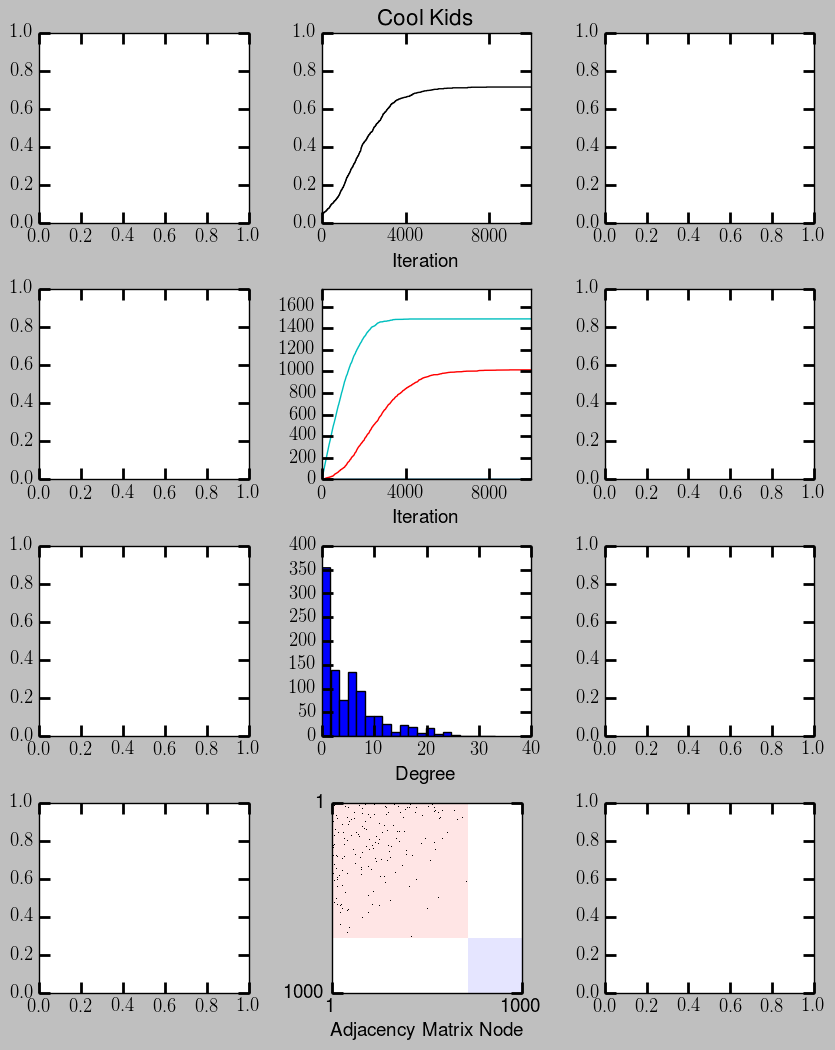

In [5]:
%run initplot.py

plt.rcParams['font.size']         = 34*.4

cnet = 'ER'
mx_init, is_infected_init = inits[cnet]['mx_init'], inits[cnet]['is_infected_init']
rdicts = rdicts_db[cnet]
N = inits[cnet]['mx_init'].shape[0]
if False:
    Ginit=nx.from_numpy_matrix(mx_init)
    print 'init  clust', nx.average_clustering(Ginit)
    print 'init  q', graphy.louvain.optimize_modularity(mx_init)[1]
    print 'init  deg assort', nx.degree_assortativity_coefficient(Ginit)
ncols = 5

#plotitems = rdicts.keys()
plotitems = ['evangelical','coolkids','veggie',]
ndicts = len(plotitems)
f, axmx = plt.subplots(4, 3, figsize=(10,4*ndicts)) # , sharex='col', sharey='row')
f.subplots_adjust(hspace=.35, wspace=.35)

axmx =axmx.T
for ndx, axrow in enumerate(axmx):
    t = plotitems[ndx]
    num_inf_ax, rewiring_ax, degree_ax, blk_ax = axrow
    if t not in rdicts:
        continue
    rdict = rdicts[t]
    colndx = 1
    print ndx, t
    if False:
        G=nx.from_numpy_matrix(rdict['mx'])
        print 'final clust', nx.average_clustering(G)
        print 'final q', graphy.louvain.optimize_modularity(rdict['mx'])[1]
        print 'final deg assort', nx.degree_assortativity_coefficient(G)

    plt.sca(num_inf_ax)
    plt.plot(np.array(rdict['num_infected'])/float(N),color='k')
    plt.title(titlecase(nicenames[t]))
    if ndx == 0: 
        plt.ylabel('Proportion infected')
    plt.xlabel('Iteration')
    from matplotlib.ticker import MaxNLocator
    plt.gca().xaxis.set_major_locator( MaxNLocator(nbins = 3) )
    #plt.locator_params(nbins=4,axis='x')

    plt.ylim([0, 1])
    # plt.plot(rdict['assortativity']);plt.title('%s - inf assortativity'%t)
    plt.sca(rewiring_ax)
    rws = np.array(rdict['rewire_counts_list'])
    rwsndx, rwtypes = zip(*[(i, rt) for i, rt in enumerate(rdict['rewire_types']) if rt[-4:]!='none'])
    if ndx == 0: 
        plt.ylabel('Cumulative rewirings')
    plotrws = rws[:,list(rwsndx)]

    plt.plot(plotrws)
    plt.xlabel('Iteration')
    plt.gca().xaxis.set_major_locator( MaxNLocator(nbins = 3) )

    plt.ylim([0, plt.ylim()[1]*1.1])
    if ndx == 2:
        labels = [str(int(item)) if ndx <1 else '' for ndx, item in enumerate(plt.gca().get_xticks())]
        plt.gca().set_xticklabels(labels)

        legend = plt.legend([legendkeys.get(rwt, rwt) for rwt in rwtypes], bbox_to_anchor=(1.1,.28), fontsize=12)
        legend.get_frame().set_facecolor('white')

    plt.sca(degree_ax)
    densemx = np.array(rdict['mx'].todense()) if ss.issparse(rdict['mx']) else rdict['mx']
    degs=densemx.sum(axis=0)
    plt.hist(degs, bins=20)  # TODO : large degrees, with frequency 1, not showing up at all
    plt.locator_params(nbins=4,axis='x')
    plt.xlabel('Degree')
    if ndx == 0:
        plt.ylabel('Frequency')

    plt.sca(blk_ax)
    if N < 2000:
        if True:
            is_infected_ixs = np.flatnonzero(rdict['is_infected'])
            is_not_infected_ixs = np.flatnonzero(~rdict['is_infected'])

            infdegs   =np.argsort(densemx[rdict['is_infected'],:].sum(axis=1))[::-1]
            notinfdegs=np.argsort(densemx[~rdict['is_infected'],:].sum(axis=1))[::-1]
            #print infdegs.max(), len(is_infected_ixs)
            #print notinfdegs.max(), len(is_not_infected_ixs),is_not_infected_ixs
            ixs = list(is_infected_ixs[infdegs]) + list(is_not_infected_ixs[notinfdegs])

            im = densemx[ixs,:][:,ixs]
            #print densemx.shape, im.shape, ixs
            #adsf
            #plt.imshow(im, cmap='Greys', aspect='auto', interpolation='nearest')
            im3 = np.zeros((N,N,3))
            im3 += (1-im[:,:,None])
            r=np.zeros((N,N))[:,:,None]+np.array([0,.1,.1])[None,None,:]
            r[len(is_infected_ixs):,:]=0
            r[:,len(is_infected_ixs):]=0
            im3 -= r
            im3[im3<0]=0
            if len(is_infected_ixs) < N:
                r=np.zeros((N,N))[:,:,None]+np.array([.1,.1,0])[None,None,:]
                r[:len(is_infected_ixs),:]=0
                r[:,:len(is_infected_ixs)]=0
                im3 -= r
                im3[im3<0]=0

            plt.imshow(im3,  interpolation='nearest')


            plt.gca().grid(b=False)
            if False:
                if len(is_infected_ixs) != N:
                    plt.plot([0, N], [len(is_infected_ixs), len(is_infected_ixs)], color='k', linestyle='-', linewidth=1)
                    plt.plot( [len(is_infected_ixs), len(is_infected_ixs)], [0, N], color='k', linestyle='-', linewidth=1)
            plt.xlim([0,N])
            plt.ylim([N,0])
            plt.xticks([0,N], ['1',str(N)])
            plt.yticks([0,N], ['1',str(N)])
            plt.xlabel('Adjacency Matrix Node')
            if ndx == 0:
                plt.ylabel('Node')

    """
    plt.sca(blk_ax)
    #plt.hist(rdict['mx'].sum(axis=0), bins=20)
    #ixs = list(np.flatnonzero(is_infected_init)) + list(np.flatnonzero(~is_infected_init))
    #plt.imshow(rdict['mx'][ixs,:][:,ixs], cmap='Greys', aspect='auto', interpolation='nearest')
    plt.scatter(rdict['time_infected'], rdict['mx'].sum(axis=0))
    plt.xlabel('time inf')
    plt.ylabel('degree')
    """

    print
fname='out/gridfig1-%s.pdf'%cnet
if False:
    print 'saving', fname
    plt.savefig(fname, facecolor='white')
    

In [ ]:
bf=get_bf_dict()['coolkids']
speedup = 0.5
NumIters=1000
rd1=run_rewire(mx_init, is_infected_init, benefit_function=bf, opts=dict(beta=beta, p_transmit=0.0001, p_rewire=0.5, NUM_ITERS=speedup*10000))
rd1b=run_rewire(mx_init, is_infected_init, benefit_function=bf, opts=dict(beta=beta, p_transmit=0.0001, p_rewire=0.5, NUM_ITERS=speedup*10000))
rd2=run_rewire(mx_init, is_infected_init, benefit_function=bf, opts=dict(beta=beta, p_transmit=0.0001*speedup, p_rewire=0.5*speedup, NUM_ITERS=10000))


In [ ]:
plt.plot(np.arange(len(rd1['num_infected'])), rd1['num_infected'])
plt.hold('on')
plt.plot(np.arange(len(rd1b['num_infected'])), rd1b['num_infected'])
plt.hold('on')
plt.plot(np.arange(len(rd2['num_infected']))*speedup, rd2['num_infected'])


In [ ]:
#%matplotlib inline
%run initplot.py
c='ER'
plt.figure(figsize=(5,4))

t='coolkids'  #for ndx,t in enumerate(rdicts_db[c]):
inf=np.array(rdicts_db[c][t]['num_infected'],dtype='float')
s=250
#plt.subplot(2,3,ndx+1)
#plt.title(t)
offset = (s-1)/2
plt.plot((inf[s:]-inf[:-s])/inf[offset:offset-s], color='k')
plt.ylabel(r'$\dot{I} / I$', fontsize=15)
plt.xlabel('Iteration')
#plt.savefig('out/rdot_over_r.pdf',bbox_inches='tight',facecolor='white')

# Scan across beta values, plot infection rates & rewiring rates

In [ ]:
cnet = 'ER'
mx_init, is_infected_init = inits[cnet]['mx_init'], inits[cnet]['is_infected_init']
mx_init_ss = ss.csr_matrix(mx_init)
print cnet, 'meank', mx_init.sum(axis=1).mean()

#save_vals2 = {} # !!!
    
beta = 100
for t in ['evangelical','coolkids','veggie',]:
    print t
    #save_vals2[t] = {} # !!!
    for pndx, p_transmit in enumerate(10**np.linspace(-6,0, 20)):
        print '%d-%0.3g'%(pndx, p_transmit), 
        bf = get_bf(t)
        n_iters = 1000000
        if p_transmit > 1e-5:
            n_iters = 200000
        if p_transmit > 1e-4:
            n_iters = 30000
        if p_transmit > 1e-2:
            n_iters = 10000
            
        r= run_rewire(mx_init_ss, is_infected_init, benefit_function=bf, 
                                           opts=dict(beta=beta, p_transmit=p_transmit, NUM_ITERS=n_iters))
        save_vals2[t][pndx] = (p_transmit, r)
        break # !!!
    break # !!!
    print
    

In [ ]:
%run initplot.py
N = mx_init.shape[0]
f, axmx = plt.subplots(2, 3, figsize=(12,8)) # , sharex='col', sharey='row')
f.subplots_adjust(hspace=.35, wspace=.35)
plt.figure(figsize=(9*4,12*4))
for tndx, t in enumerate(['evangelical','coolkids','veggie',]):
    if t not in save_vals2:
        continue
    d=save_vals2[t]
    for i in range(len(d)):
        xx=  np.array(d[i][1]['num_infected'])
        #print xx[-1000:].min(),xx.max()
        #plt.figure()
        #plt.plot(xx)
    ps, numinfs = zip(*[(d[i][0], d[i][1]['num_infected'][-1]) for i in range(len(d))])
    #plt.subplot(3,2,tndx*2+1)
    plt.sca(axmx[0,tndx])
    plt.semilogx(ps, np.array(numinfs)/float(N), color='k')
    plt.ylim([0, 1.05*plt.ylim()[1]])
    plt.xlabel(r'$\beta$', fontsize=18)
    plt.ylabel('Proportion infected')
    plt.vlines(0.0002, plt.ylim()[0], plt.ylim()[1], colors='k', linestyles='--', linewidth=1)
    plt.title(titlecase(nicenames[t]))
    #plt.subplot(3,2,tndx*2+2)
    plt.sca(axmx[1,tndx])
    all_rwts = [ 'i-i->n', 'n-i->n', 'i-n->i',  'n-n->i']
    for rwt in all_rwts:
        clist = []

        for i in range(len(d)):
            ix = [ndx for ndx, c in enumerate(d[i][1]['rewire_types']) if c == rwt][0]
            clist.append((d[i][0], np.array(d[i][1]['rewire_counts_list'])[-1,ix]))
        ps, data = zip(*clist) 
        plt.semilogx(ps, data)
    plt.xlabel(r'$\beta$', fontsize=18)
    plt.ylabel('Total number rewirings')
    plt.vlines(0.0002, plt.ylim()[0], plt.ylim()[1], colors='k', linestyles='--', linewidth=1)
    if tndx == 0:
        legend = plt.legend([legendkeys.get(rwt, rwt) for rwt in all_rwts], bbox_to_anchor=(1.06,1), fontsize=12)
        legend.get_frame().set_facecolor('white')

plt.savefig('out/ptransmit_sweep_v2.pdf', bbox_inches='tight',facecolor='white')

In [ ]:
#import cPickle
#cPickle.dump([ mx_init, save_vals2],open('s.dat', 'wb'))
#mx_init, save_vals2 = cPickle.load(open('s.dat','rb'))